# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

## PartB Question 1

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import graphviz
import pydot_ng as pydot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from math import floor


In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from keras import backend as K
from math import sqrt 

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [6]:
def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Question 1

In [7]:
# Split data

train_dataframe = df[df['year']<= 2020] 
test_dataframe =  df[df['year']>2020]

In [8]:
train_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [9]:

category_not_used = ["full_address", "nearest_stn"]
train_dataframe = train_dataframe.drop(category_not_used, axis = 1)
test_dataframe = test_dataframe.drop(category_not_used, axis = 1)

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

## Question 1A 
#### Why is this done instead of using random train/test split?

**The rationale is to predict resale prices is to used past data as the training dataset to predict future values. Hence the training dataset are used for year <= 2020 and the test dataset are filled by the more recent dataset**


## Question 1B 

In [10]:
#Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
#resale_price = keras.Input(shape=(1,), name="resale_price")

all_inputs = [month,flat_model_type,storey_range,dist_to_nearest_stn,
            dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm]


#Integer categorical features
month_encoded = encode_categorical_feature(month, "month",train_ds, False)

#String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type",train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range",train_ds, True)

#Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", train_ds)

all_features = layers.Concatenate()(
                [
                    month_encoded,
                    storey_range_encoded,
                    flat_model_type_encoded,
                    floor_area_sqm_encoded,
                    remaining_lease_year_encoded,
                    degree_centrality_encoded,
                    eigenvector_centrality_encoded,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded
                ]
)
output = layers.Dense(1, activation="linear")(all_features)
adam_model = keras.Model(all_inputs, output)
adam_model.compile(optimizer="adam", loss= "mse",metrics=[r2])


#### **ARCHITECTURE**

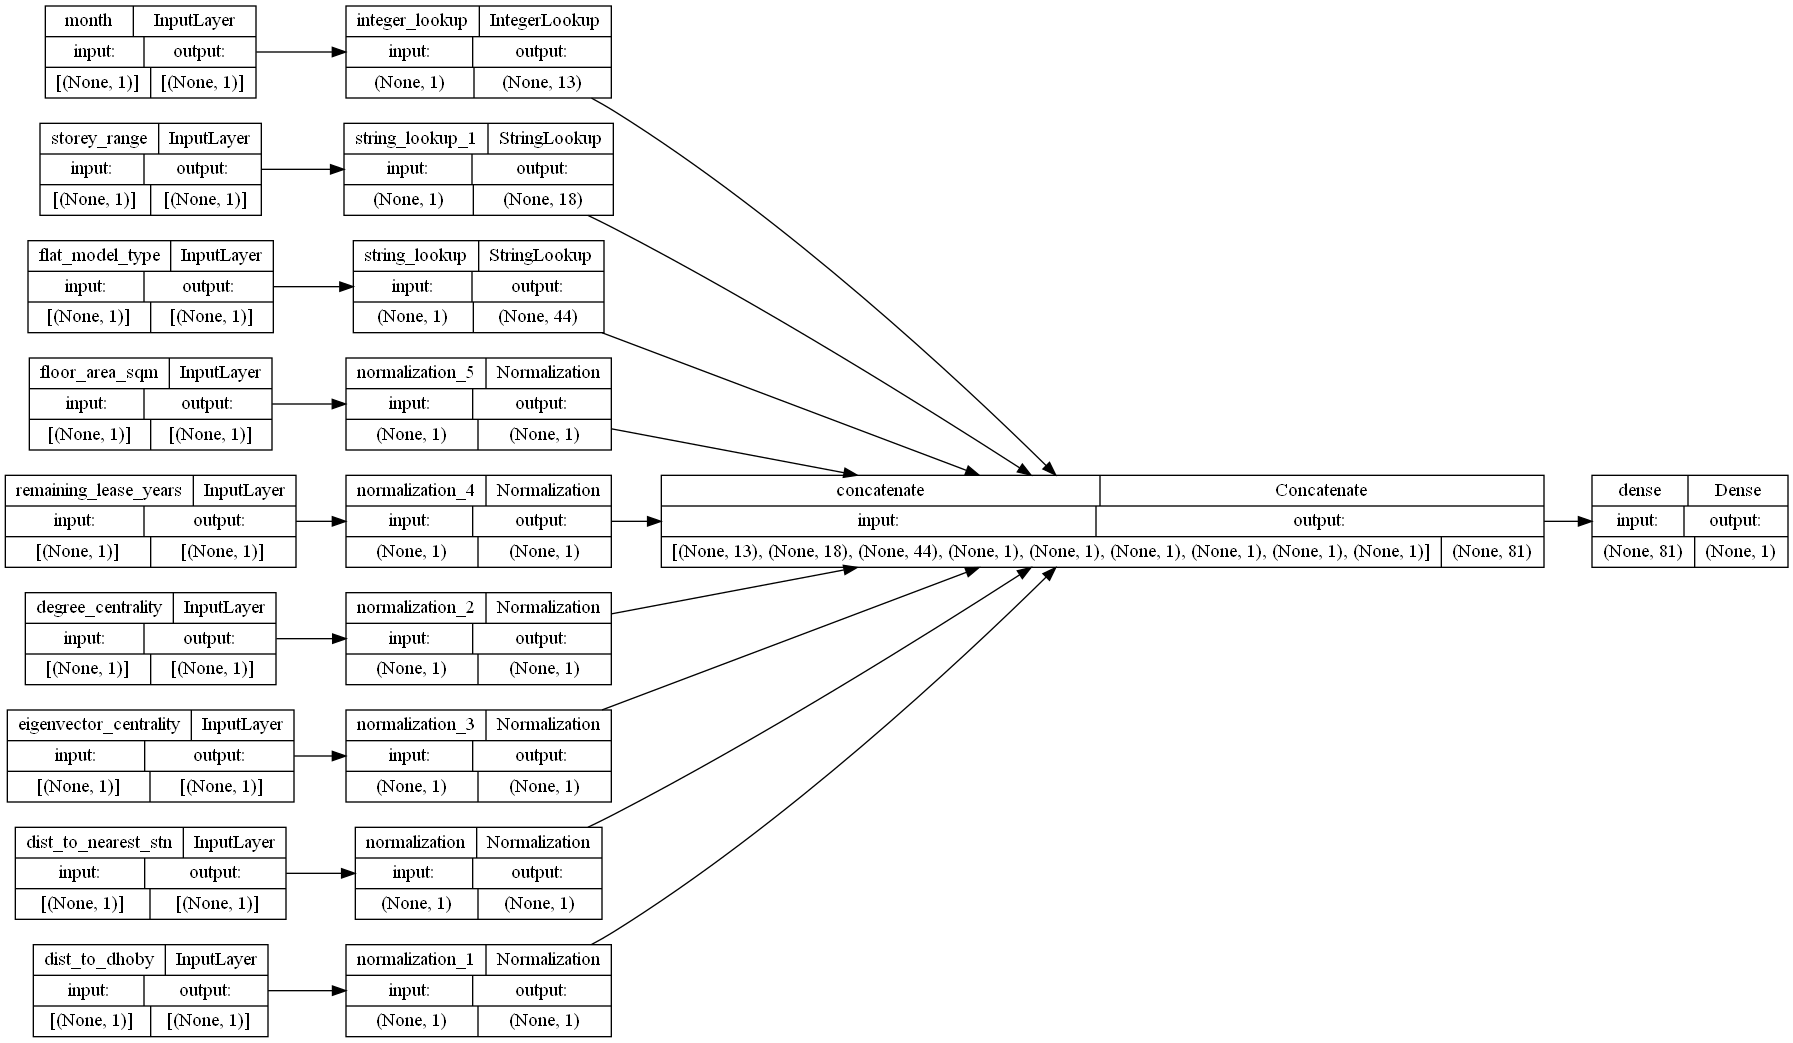

In [11]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(adam_model, show_shapes=True, rankdir="LR")

## Question 1C
#### Training **Adam** model and **SGD** model 

In [12]:
history = {}
no_epochs = 50
batch_size = 256
history["adam_model"] = adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 3s 6ms/step - loss: 219585937408.0000 - r2: -8.3474 - val_loss: 301486735360.0000 - val_r2: -10.0832
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: 219584561152.0000 - r2: -8.3520 - val_loss: 301485064192.0000 - val_r2: -10.0722
Epoch 3/50
342/342 [==============================] - 2s 5ms/step - loss: 219583217664.0000 - r2: -8.3501 - val_loss: 301483458560.0000 - val_r2: -10.1026
Epoch 4/50
342/342 [==============================] - 2s 6ms/step - loss: 219581857792.0000 - r2: -8.3437 - val_loss: 301481951232.0000 - val_r2: -10.0800
Epoch 5/50
342/342 [==============================] - 2s 6ms/step - loss: 219580661760.0000 - r2: -8.3458 - val_loss: 301480378368.0000 - val_r2: -10.1214
Epoch 6/50
342/342 [==============================] - 2s 5ms/step - loss: 219579383808.0000 - r2: -8.3513 - val_loss: 301478903808.0000 - val_r2: -10.0838
Epoch 7/50
342/342 [==============================] - 2s 4ms/step - loss: 2195780

#### Training of **SGD model** with learning rate **0.01**

In [13]:
custom_optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
sgd_model = keras.Model(all_inputs, output)
sgd_model.compile(optimizer=custom_optimizer, loss="mse", metrics=[r2])
history["sgd_model"] = sgd_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50
342/342 [==============================] - 3s 6ms/step - loss: 18724683776.0000 - r2: 0.1967 - val_loss: 13789808640.0000 - val_r2: 0.4959
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: 5481839616.0000 - r2: 0.7678 - val_loss: 12796226560.0000 - val_r2: 0.5320
Epoch 3/50
342/342 [==============================] - 2s 5ms/step - loss: 5026614272.0000 - r2: 0.7875 - val_loss: 12325055488.0000 - val_r2: 0.5501
Epoch 4/50
342/342 [==============================] - 2s 5ms/step - loss: 4776948224.0000 - r2: 0.7976 - val_loss: 12102066176.0000 - val_r2: 0.5574
Epoch 5/50
342/342 [==============================] - 2s 4ms/step - loss: 4609028096.0000 - r2: 0.8049 - val_loss: 11926619136.0000 - val_r2: 0.5641
Epoch 6/50
342/342 [==============================] - 2s 4ms/step - loss: 4482668544.0000 - r2: 0.8106 - val_loss: 11662412800.0000 - val_r2: 0.5736
Epoch 7/50
342/342 [==============================] - 2s 4ms/step - loss: 4384758272.0000 - r2: 0.8140 - 

In [14]:
data = {"Q1C_Adam_Train R^2": [history["adam_model"].history["r2"][-1]],
        "Q1C_Adam_Val R^2": [history["adam_model"].history["val_r2"][-1]],
        "SGD_Train R^2": [history["sgd_model"].history["r2"][-1]],
        "SGD_Val R^2": [history["sgd_model"].history["val_r2"][-1]]
       }
data_df = pd.DataFrame.from_dict(data)
data_df

,Q1C_Adam_Train R^2,Q1C_Adam_Val R^2,SGD_Train R^2,SGD_Val R^2
0,-8.350127,-10.073879,0.840261,0.610094


#### Report why the change to SGD fixes the problem faced when using Adam optimiser

**From the table above, we can see the difference in R^2 for both Adam and SGD optimiser.**

**Adam algorithm is leverages on the power of adaptive learning rates methods to find individual learning rates for each parameter. Due to the low learning rate of the Adam optimiser, it is very likely that it does not have sufficient iteration time to converge to minima and yield a decent R^2 value**

**SGD algorithm with a learning rate of 0.01 allows the model to generalize faster and converge faster to minima**

## Question 1D 
#### Training of **Adam** model with learning rate of **0.08**

In [15]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.08)
hidden_layer = layers.Dense(10, activation ="linear")(all_features)
Q1D_output = layers.Dense(1, activation="linear")(hidden_layer)
Q1D_adam_model = keras.Model(all_inputs, Q1D_output)
Q1D_adam_model.compile(optimizer=adam_optimizer, loss= "mse",metrics=[r2])

In [16]:
history["Q1D_adam_model"] = Q1D_adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 2s 5ms/step - loss: 198604013568.0000 - r2: -7.4464 - val_loss: 226039087104.0000 - val_r2: -7.3163
Epoch 2/50
342/342 [==============================] - 2s 4ms/step - loss: 99525992448.0000 - r2: -3.2406 - val_loss: 88990212096.0000 - val_r2: -2.2731
Epoch 3/50
342/342 [==============================] - 2s 4ms/step - loss: 23373901824.0000 - r2: 0.0066 - val_loss: 25650937856.0000 - val_r2: 0.0618
Epoch 4/50
342/342 [==============================] - 2s 4ms/step - loss: 6420192256.0000 - r2: 0.7287 - val_loss: 14056211456.0000 - val_r2: 0.4869
Epoch 5/50
342/342 [==============================] - 2s 4ms/step - loss: 5106189312.0000 - r2: 0.7841 - val_loss: 12450711552.0000 - val_r2: 0.5452
Epoch 6/50
342/342 [==============================] - 2s 4ms/step - loss: 4765254144.0000 - r2: 0.7983 - val_loss: 11993393152.0000 - val_r2: 0.5622
Epoch 7/50
342/342 [==============================] - 2s 4ms/step - loss: 4506056704.0000 - r2: 0.8093 - val

## Question 1E 


In [17]:
# Compare with a table and explain
Q1_data = {"Q1D_Adam_Train R^2": [history["Q1D_adam_model"].history["r2"][-1]],
        "Q1D_Adam_Val R^2": [history["Q1D_adam_model"].history["val_r2"][-1]],
        "Q1C_Adam_Train R^2": [history["adam_model"].history["r2"][-1]],
        "Q1C_Adam_Val R^2": [history["adam_model"].history["val_r2"][-1]],
        "SGD_Train R^2": [history["sgd_model"].history["r2"][-1]],
        "SGD_Val R^2": [history["sgd_model"].history["val_r2"][-1]]
        }


data_df = pd.DataFrame.from_dict(Q1_data)
data_df

,Q1D_Adam_Train R^2,Q1D_Adam_Val R^2,Q1C_Adam_Train R^2,Q1C_Adam_Val R^2,SGD_Train R^2,SGD_Val R^2
0,0.845678,0.628727,-8.350127,-10.073879,0.840261,0.610094


#### Compare the performance of 1C and 1D to the linear regression model and suggest reasons for the observations

**From the table, the validation R^2 value from Q1D(0.628727) is higher than the linear regression model (0.627) and the validation R^2 value from Q1C(SGD 0.610094) is lower than the linear regression model(0.627).** 

**In Q1C, the SGD model do not have the complexity to discover and learn the relationships between the input features and thus leading to a poorer result compared to the linear regression model.**

**In 1D, there is an additional hidden layer and a rise in learning rate for the Adam optimiser.Thus, performance of the network model will be better as with the hidden layer, the network model is able to capture more complexity and discover relationships between the features in the input.**

**Also, with the higher learning rate, the modified adam optimiser will converge faster.**